<a href="https://colab.research.google.com/github/JoaoGranja/Indoor_object_detection/blob/master/indoor_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indoor Object Detection

In this project, I loaded the Indoor Object Detection dataset (https://zenodo.org/record/2654485#.YaYShVPMJhE) and train a custom YOLOv5 model to recognize the objects in our dataset. To do so I will take the following steps::

1.   **Setup Code**
2.   **Data Preprocessing**
  
  a Convert the Annotations into the YOLO v5 Format 
  
  b) Testing the annotations
3.   **Partition the Dataset**
4.   **Training Yolo v5 model**
5.   **Show training/validation results**
6.   **Testing**
7.   **Future Work**




# Step 1: Setup Code

In [1]:
# Package Installation and share Google Drive    
!pip install --upgrade pip


from google.colab import drive    
drive.mount('/content/drive', force_remount=True)

import os, sys
sys.path.append('/content/drive/MyDrive/colab/DocuSketch')
os.chdir('/content/drive/MyDrive/colab/DocuSketch')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [2]:
# Clone GitHub repository, install dependencies and check PyTorch and GPU.
if not os.path.isdir('yolov5'):
    #Import yolov5 model
    !git clone https://github.com/ultralytics/yolov5  # clone

%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.5/78.2 GB disk)


In [3]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# Step 2: Data Preprocessing

In [4]:
os.chdir('/content/drive/MyDrive/colab/DocuSketch/Indoor Object Detection Dataset')

if os.path.isdir('images'):  
  shutil.rmtree('images')
if os.path.isdir('annotations'): 
  shutil.rmtree('annotations')
if os.path.isdir('labels'): 
  shutil.rmtree('labels')

!mkdir images
!mkdir labels
!mkdir annotations

## a) Convert the Annotations into the YOLO v5 Format

In [5]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info_list 
    info_list = []
    
    # Parse the XML Tree
    for image in root.iter('image'):
        image_dict = {}
        image_dict['bboxes'] = []
        # Get the file name 
        if 'file' in image.attrib:
            image_dict['filename'] = image.attrib['file']

        for box in image.iter('box'):
            # Get details of the bounding box 
            bbox = box.attrib

            for label in box:
                if label.tag == "label":
                    bbox["class"] = label.text
                            
            image_dict['bboxes'].append(bbox)
        
        info_list.append(image_dict)
    
    return info_list

In [6]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"fireextinguisher": 0,
                            "chair": 1,
                            "exit": 2,
                            "clock": 3,
                            "trashbin": 4,
                            "screen": 5,
                            "printer": 6}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_list):
    image_w, image_h = 1280,720
    
    # For each bounding box
    for info in info_list:
        print_buffer = []
        for b in info["bboxes"]:
            try:
                class_id = class_name_to_id_mapping[b["class"]]
            except KeyError:
                print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
            
            # Transform the bbox co-ordinates as per the format required by YOLO v5
            b_center_x = int(b["left"]) + (int(b["width"]) / 2)
            b_center_y = int(b["top"]) + (int(b["height"]) / 2)
            b_width    = int(b['width'])
            b_height   = int(b['height'])
            
            # Normalise the co-ordinates by the dimensions of the image
            b_center_x /= image_w 
            b_center_y /= image_h 
            b_width    /= image_w 
            b_height   /= image_h 
            
            #Write the bbox details to the file 
            print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
            
        # Name of the file which we have to save 
        save_file_name = os.path.join("annotations", info["filename"].replace("jpg", "txt"))
        
        # Save the annotation to disk
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [7]:
# Get the annotations
annotations = [os.path.join('annotation', x) for x in os.listdir('annotation') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]


100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


In [8]:
# Get the images
sequence_list = [x for x in os.listdir('.') if 'sequence' in x]

for sequence in tqdm(sequence_list):
    try:
        shutil.copytree(sequence, 'images', dirs_exist_ok=True)
    except:
        print(sequence)
        assert False


100%|██████████| 6/6 [00:25<00:00,  4.24s/it]


## b) Testing the annotations

Label = exit


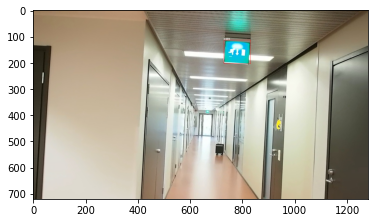

In [9]:
# random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_file):
  with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline='red')
        
        print(f"Label = {class_id_to_name_mapping[(int(obj_cls))]}")
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)

# Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
# print(image_file, annotation_file)
assert os.path.exists(image_file)

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, annotation_file)

# Step 3: Partition the Dataset

In [10]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [11]:
!mkdir images/train images/val images/test labels/train labels/val labels/test

In [12]:
# Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')

# Step 4: Training Yolo v5 model

For this case we use the following hyper parameters:

- **img:** 640
- **batch:** 32
- **epochs:** 50
- **model architecture:** yolov5s
- **yperparameter config file:** hyp.scratch-low.yaml
- **data config:** custom indoor.yaml created below
- **weights:** yolov5s.pt
- **train name:** indoor_yolo
- **cache:** cache images for faster training

In [13]:
os.chdir('/content/drive/MyDrive/colab/DocuSketch/yolov5')

In [14]:
text = """train: ../Indoor Object Detection Dataset/images/train/ 
val:  ../Indoor Object Detection Dataset/images/val/
test: ../Indoor Object Detection Dataset/images/test/

# number of classes
nc: 7

# class names
names: ["fireextinguisher", "chair", "exit", "clock", "trashbin", "screen", "printer"]"""
with open('data/indoor.yaml', 'w') as f:
  f.write(text)

In [15]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 50 --data indoor.yaml --weights yolov5s.pt --workers 24 --name indoor_yolo --cache

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=indoor.yaml, hyp=hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=indoor_yolo, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hs

## Show training/validation results

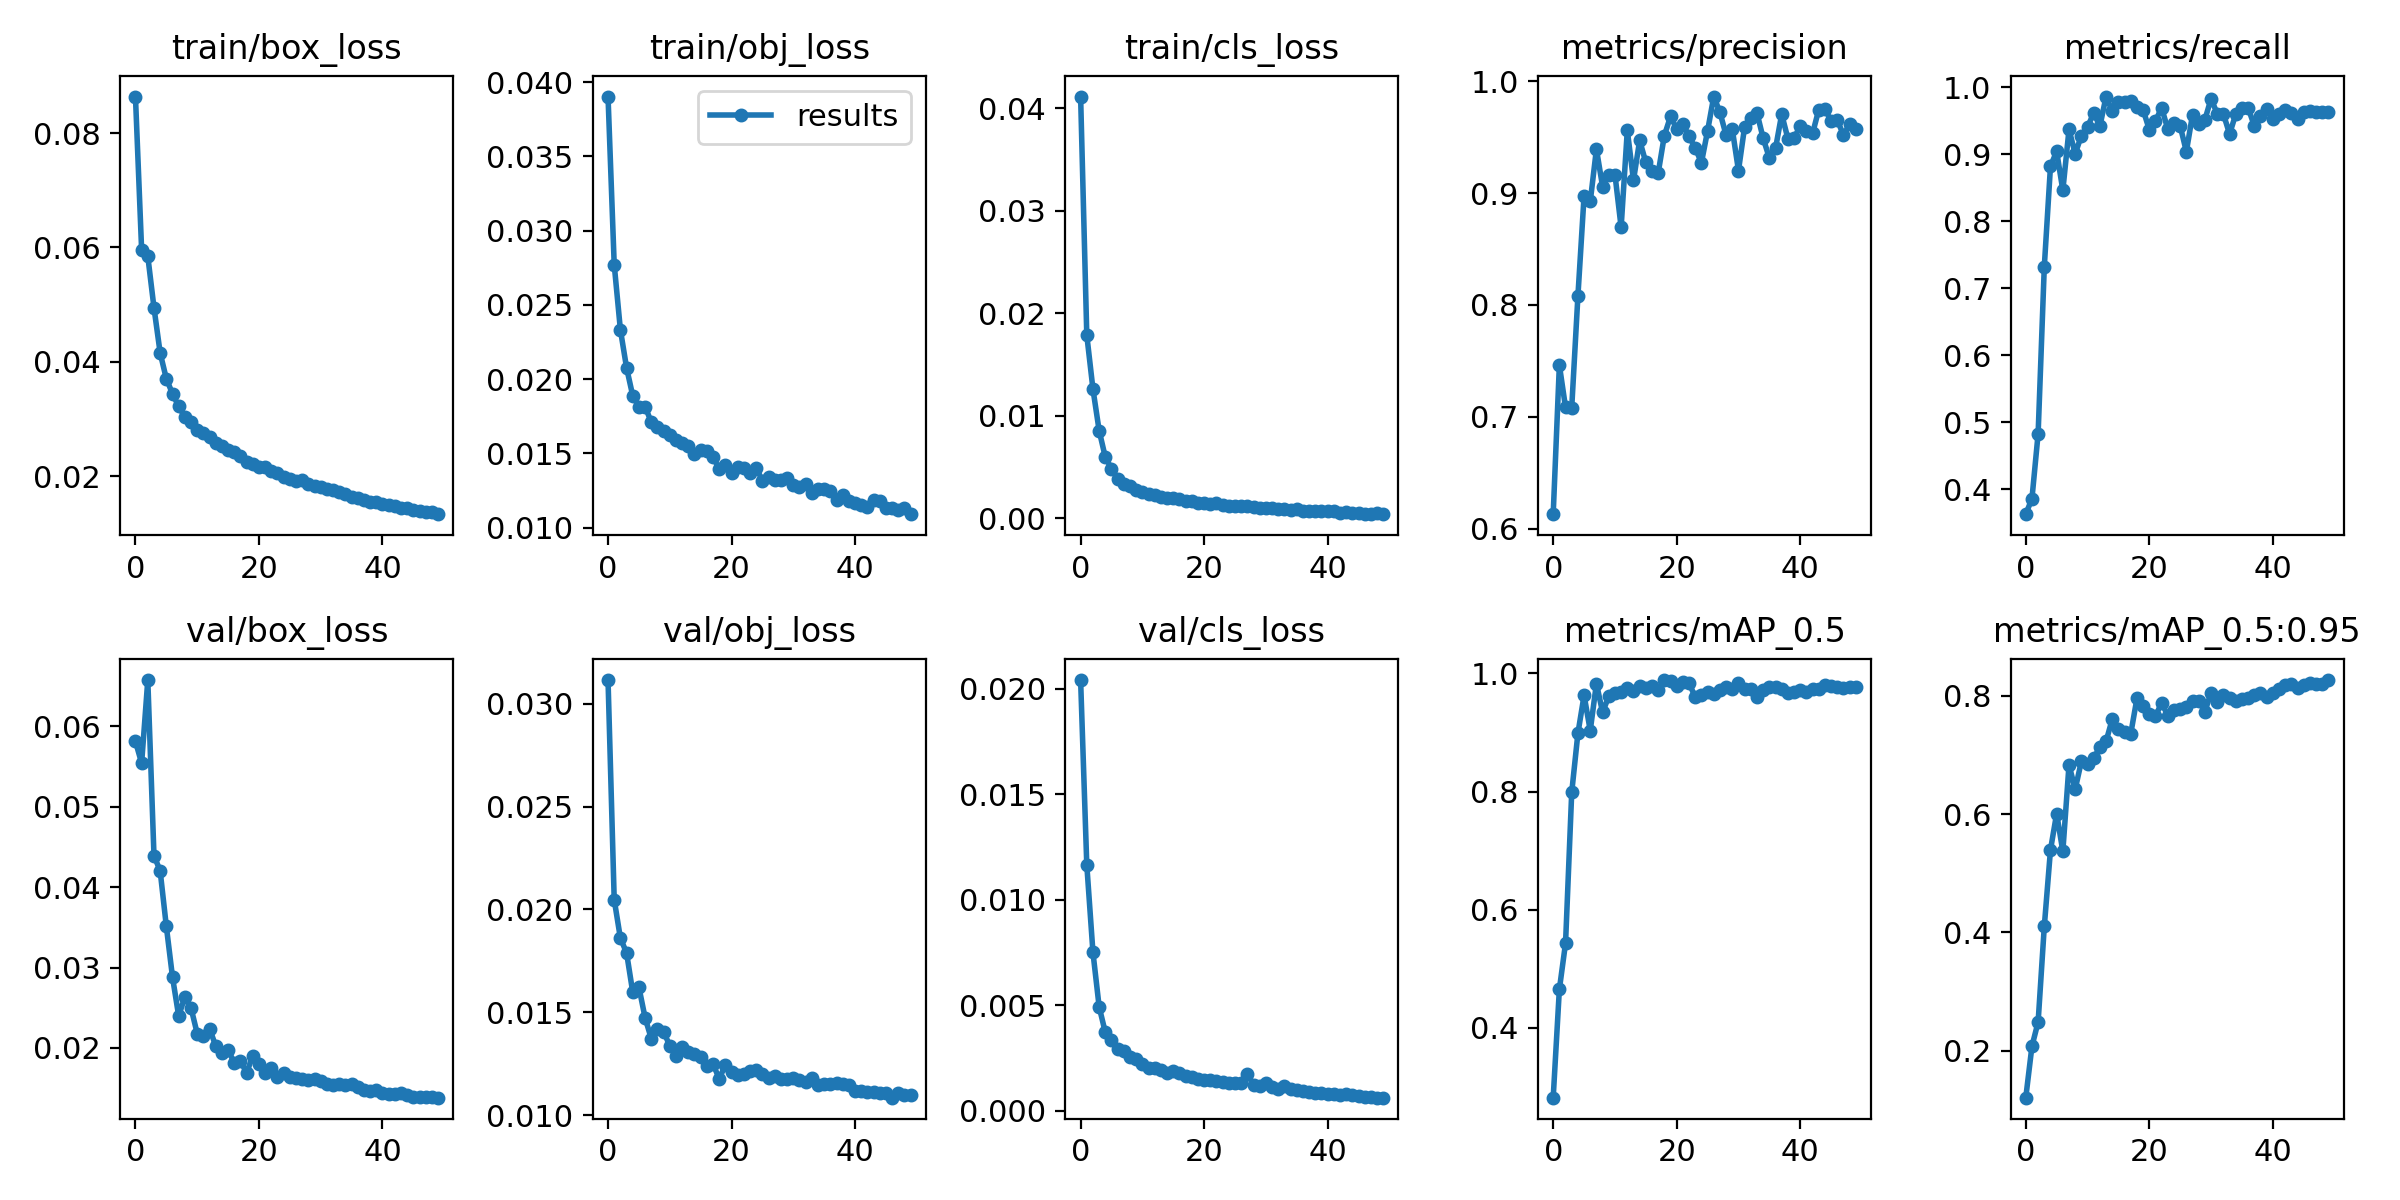

In [16]:
from utils.plots import plot_results 
plot_results('runs/train/indoor_yolo/results.csv')  # plot 'results.csv' as 'results.png'
display.Image(filename='runs/train/indoor_yolo/results.png')

# Step 5: Inference
Run inference with the best trained weights over testing dataset


In [17]:
!python detect.py --source '../Indoor Object Detection Dataset/images/test/' --weights runs/train/indoor_yolo/weights/best.pt --conf 0.25 --name indoor_yolo_det

detect: weights=['runs/train/indoor_yolo/weights/best.pt'], source=../Indoor Object Detection Dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=indoor_yolo_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
image 1/222 /content/drive/MyDrive/colab/DocuSketch/Indoor Object Detection Dataset/images/test/frame_s1_101.jpg: 384x640 3 chairs, 12.3ms
image 2/222 /content/drive/MyDrive/colab/DocuSketch/Indoor Object Detection Dataset/images/test/frame_s1_106.jpg: 384x640 2 chairs, 8.8ms
image 3/222 /content

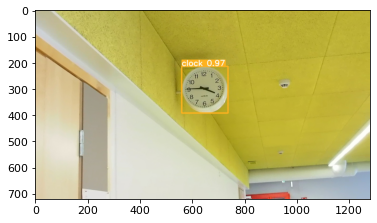

In [18]:
# Show example of a detection image
detections_dir = "runs/detect/indoor_yolo_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

# Step 6: Testing
Testing best trained model over testing dataset. 
We will get mAP50 for all classes and showing testing results as well as some good and bad examples (comparing original images+annotations and corresponding detection images)

In [28]:
!python val.py --weights runs/train/indoor_yolo/weights/best.pt --data indoor.yaml --task test --name yolo_det

val: data=/content/drive/MyDrive/colab/DocuSketch/yolov5/data/indoor.yaml, weights=['runs/train/indoor_yolo/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Traceback (most recent call last):
  File "val.py", line 408, in <module>
    main(opt)
  File "val.py", line 379, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.8/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "val.py", line 142, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
  File "/content/drive/MyDrive/colab/DocuSketch/yolov5/models/common.py", line 345, in __in

### Show some testing results

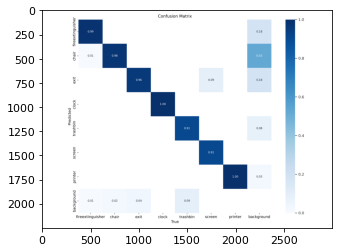

In [20]:
# Confusion Matrix
plt.imshow(np.array(Image.open("runs/val/yolo_det/confusion_matrix.png")))

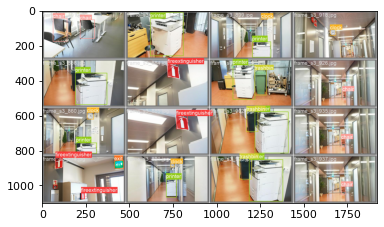

In [21]:
# Original images with labels for batch 0
plt.imshow(np.array(Image.open("runs/val/yolo_det/val_batch0_labels.jpg")))

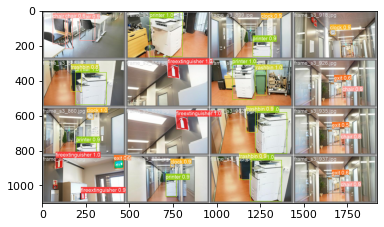

In [22]:
# Prediction images for batch 0
plt.imshow(np.array(Image.open("runs/val/yolo_det/val_batch0_pred.jpg")))

## Good example
To choose a good example I compared the previous two images and pick the image name where the bouxing boxes and class match.

Label = clock
Label = printer


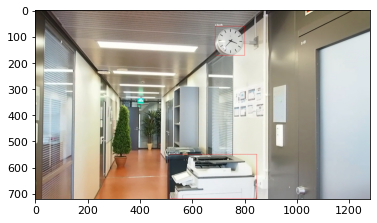

In [23]:
# Original image
image_name = 'frame_s3_860.jpg'
image_file = os.path.join('/content/drive/MyDrive/colab/DocuSketch/Indoor Object Detection Dataset/images/test', image_name)

# Get the corresponding label file
label_file = image_file.replace("images", "labels").replace("jpg", "txt")

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, label_file)

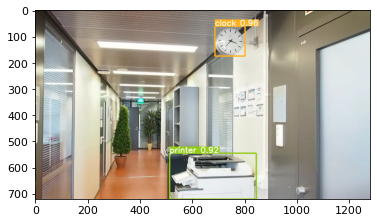

In [24]:
# Prediction
prediction_image_path = os.path.join('runs/detect/indoor_yolo_det/', image_name)
prediction_image = Image.open(prediction_image_path)
plt.imshow(np.array(prediction_image))

Comparing the 2 previous images we can verify that the Yolo v5 model detects both clock and printer with high confidence.

## Bad Example
To choose a bad example I compared the previous images and pick the image name where the bouxing boxes and class didn't match.

Label = printer


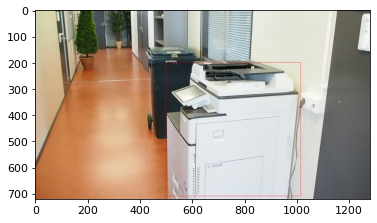

In [25]:
# Original image
image_name = 'frame_s3_858.jpg'
image_file = os.path.join('/content/drive/MyDrive/colab/DocuSketch/Indoor Object Detection Dataset/images/test', image_name)

# Get the corresponding label file
label_file = image_file.replace("images", "labels").replace("jpg", "txt")

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, label_file)

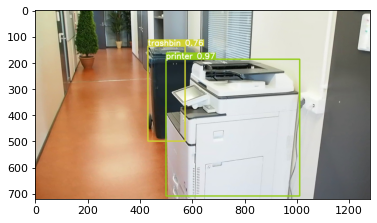

In [26]:
# Prediction
prediction_image_path = os.path.join('runs/detect/indoor_yolo_det/', image_name)
prediction_image = Image.open(prediction_image_path)
plt.imshow(np.array(prediction_image))

Comparing the 2 previous images we can verify that the Yolo v5 model detects a trashbin while in the original image, there is no label for it.

# Step 7: Future Work

Several steps can be taken to improve indoor object detection performance such as:


*   try training a bigger model architecture (yolov5m, yolov5l, ...)
*   explore different data augmentation
*   split the dataset by sequence
*   train a different object detection model (FasterRVNN, RetinaNet,...) 


